# Report on possibilities for exploration of concepts

<div style="text-align: right"> who worked on this document: Amelie, Renato </div>

This report is one of the sub-products of the discussions registered in [this](https://docs.google.com/document/d/1E9QCUO6kzD20H8pSXmZasA0t08KUbzFJGOae5WZdRBY/edit) document.  

Basically, we assume that we are developing user interfaces to access some kind of document (pictures, texts, reports, DB entries) in which the user will be offered relevant items as a result of his/her query.  
Traditionally, the [similarity](https://en.wikipedia.org/wiki/Similarity_measure) among a query and the documents in a particular collection is measured by some common characteristics, as the raw word frequency, in order to generate a ranking (ordering) of relevant results.  
These [semantic similarities](https://en.wikipedia.org/wiki/Semantic_similarity) can be calculated by many different algoritms, as the [Vector Space](https://en.wikipedia.org/wiki/Vector_space_model) models.  

The goal of this document is to show alternatives to enhance the similarity functions by adding semantically related documents documents to the results, even though they may not share common words.

Loading Python packages

In [1]:
import random
import time
import pickle
import sys
import json
import re
import string
import collections
import codecs
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpld3

from sklearn import feature_extraction

import gensim
from gensim import corpora
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

import pyLDAvis
import pyLDAvis.gensim

import nltk
from nltk.corpus import stopwords
from nltk.tag.sequential import ClassifierBasedTagger
#from nltk.stem.wordnet import WordNetLemmatizer
#from nltk.tokenize import word_tokenize

#sudo apt-get install python-dev graphviz libgraphviz-dev pkg-config
#sudo pip install pygraphviz
import pygraphviz 
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

pd.options.mode.chained_assignment = None  # default='warn'

### Strategy #1: using the concepts in the DBO@EMA frage

the concepts were extracted from the fragebogen(questionnaires)/frage(questions) and we have now a table that contains the lemmatized version of them. We have also separated the words considered to be auxiliary in the questions (syntactic) and the relevant concepts (semantic)

In [3]:
frage = pd.read_pickle('./frage.pickle')
frage.head(10)

,fragebogen_id,nummer,original_frage,main_theme,question_words,semantic_words,syntactic_words
0,1,A1,"Kopf: Kopf, Haupt; auch scherzh./übertr.",[kopf],"[übertragen, haupt, scherzhaft, kopf]","[haupt, kopf]","[übertragen, scherzhaft]"
1,1,A2,Kopf: Kopf/Haupt (in urspr. Bed.) in Vergl./Ra...,[kopf],"[zerspringen, ursprünglich, möchten, redensart...","[zerspringen, ursprünglich, möchten, stehen, v...","[redensarten, bedeutung]"
2,1,A3,Kopf: Kopf/Haupt (übertr.) in Vergl./Ra. (das ...,[kopf],"[übertragen, redensarten, vergleich, verdrehen...","[vergleich, verdrehen, fein, offen, jemand, ha...","[übertragen, redensarten]"
3,1,A4,"Kopf: schöner, ebenmäßig gebauter Kopf (Christ...",[kopf],"[tituskopf, schön, gebaut, christuskopf, ebenm...","[tituskopf, schön, gebaut, christuskopf, ebenm...",[]
4,1,A4a,"Kopf: häßlicher, unebenmäßiger Kopf",[kopf],"[unebenmäßig, häßlich, kopf]","[unebenmäßig, häßlich, kopf]",[]
5,1,A5,Kopf: großer Kopf; großkopfig,[kopf],"[groß, großkopfig, kopf]","[groß, großkopfig, kopf]",[]
6,1,A5a,Kopf: Wasserkopf,[kopf],"[wasserkopf, kopf]","[wasserkopf, kopf]",[]
7,1,A6,Kopf: kleiner Kopf,[kopf],"[klein, kopf]","[klein, kopf]",[]
8,1,A7,Kopf: oben zugespitzter Kopf,[kopf],"[oben, zugespitzt, kopf]","[oben, zugespitzt, kopf]",[]
9,1,A8,Kopf: langer Kopf,[kopf],"[lang, kopf]","[lang, kopf]",[]


We can, for example, examine the words that co-occur in specific frage(questions) in a given fragebogen(questionnaires), as the graph below illustrates:

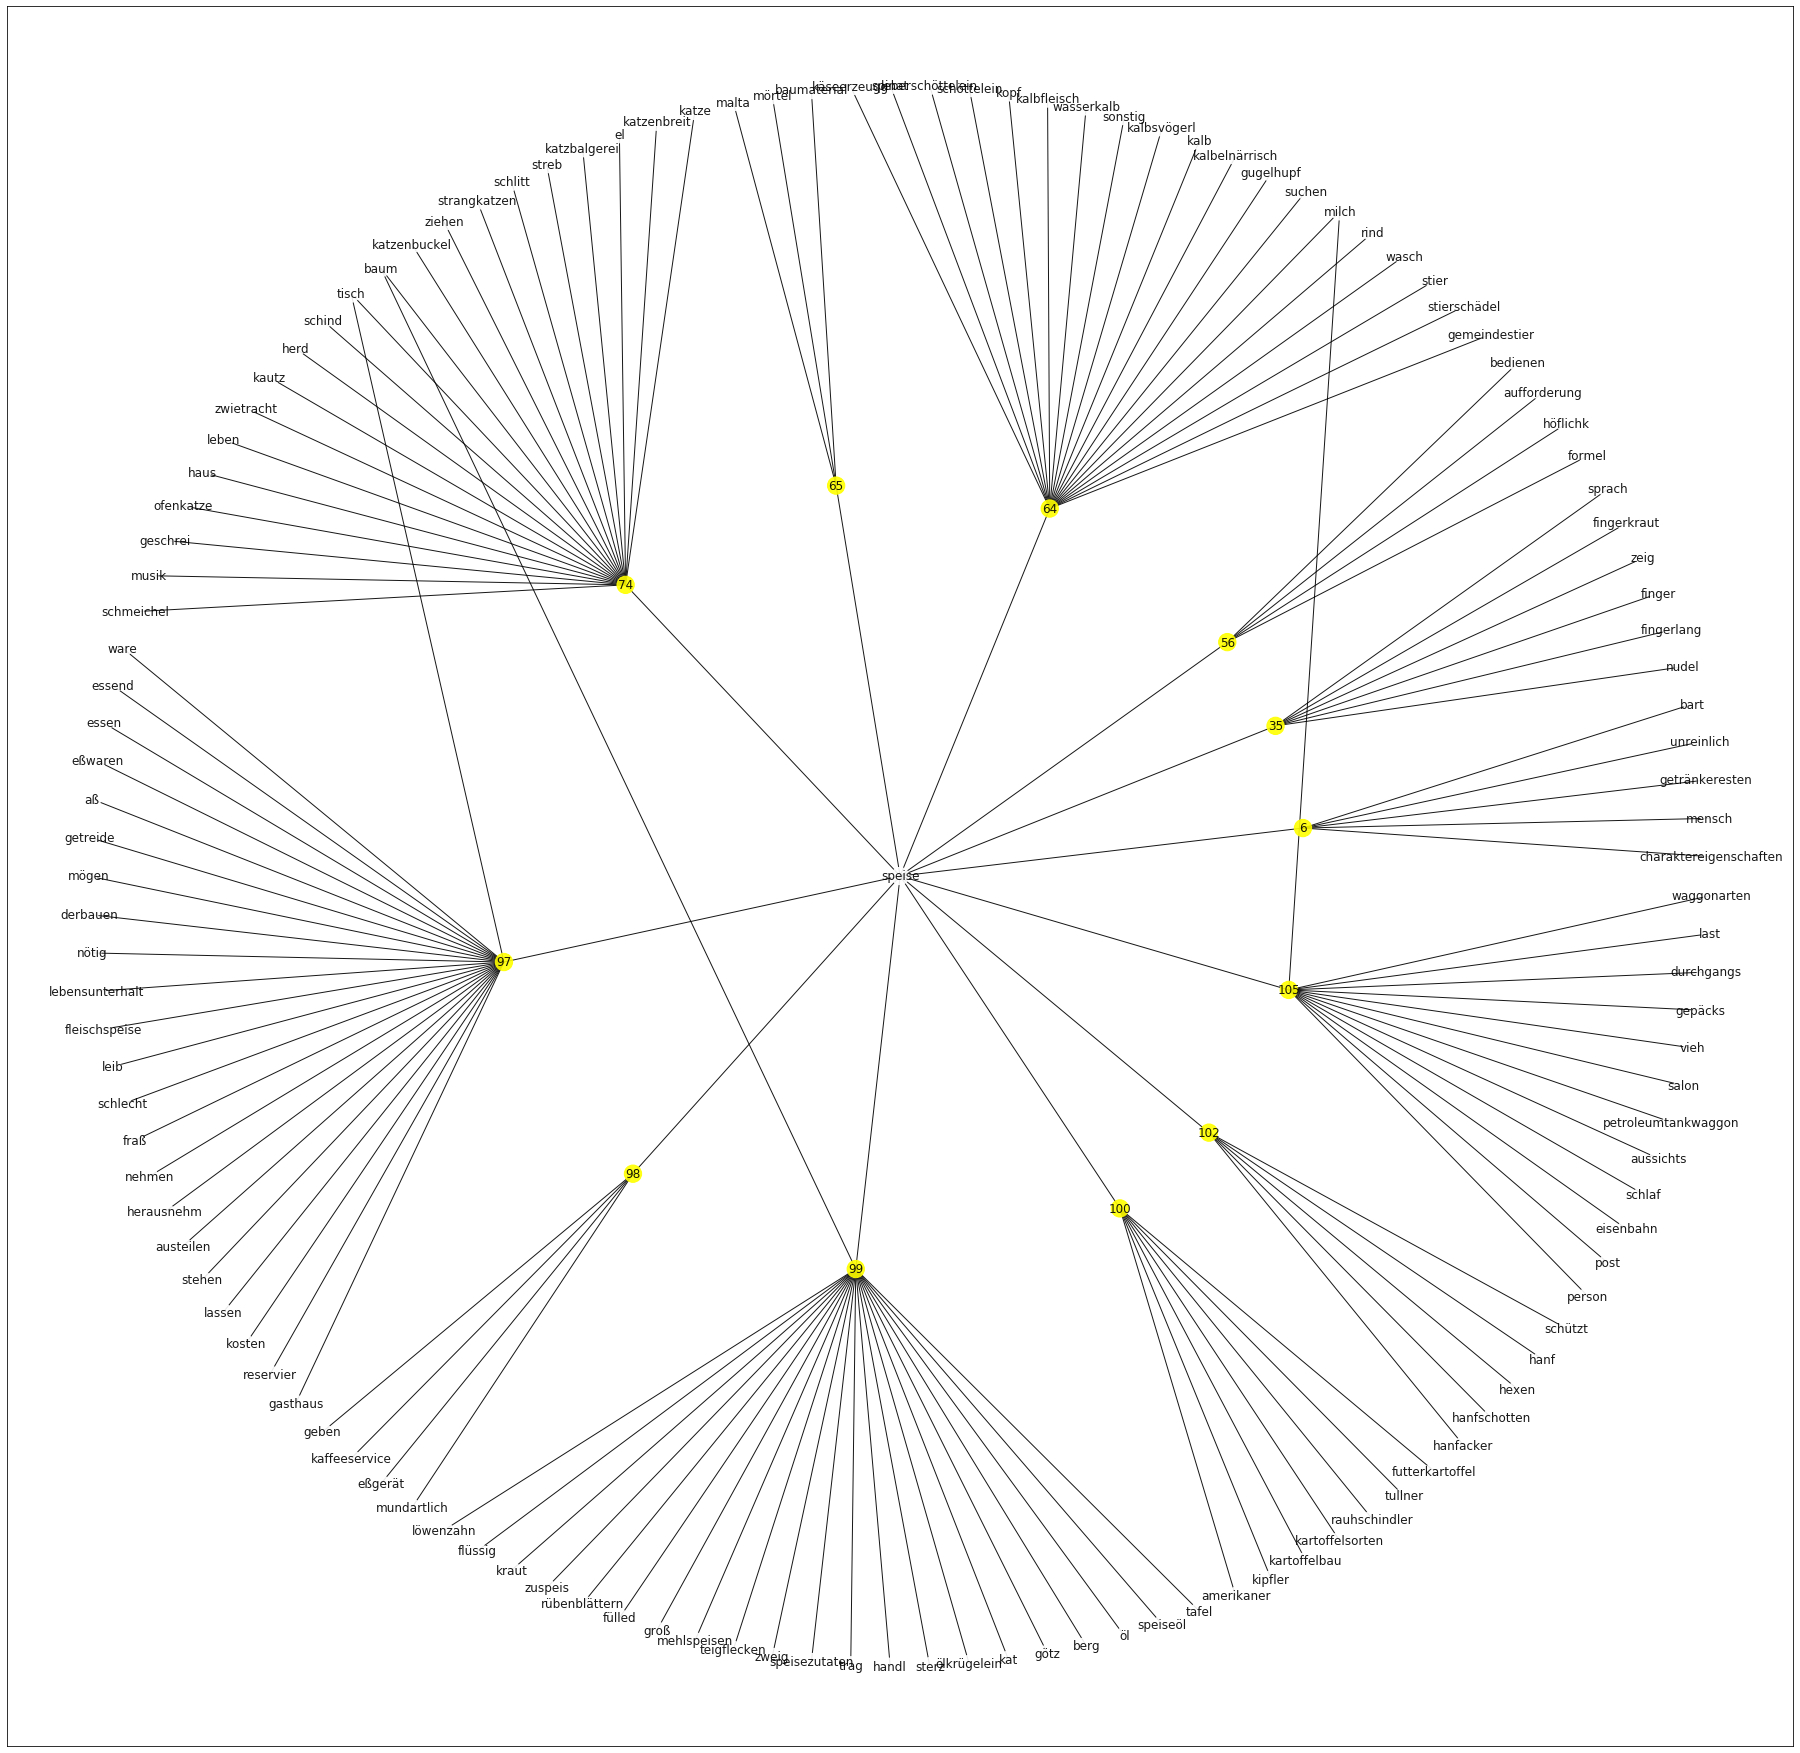

In [6]:
#cfilter = "kopf"
#cfilter = "schwarz"
#cfilter = "suppe"
cfilter = "speise"
filtered = frage[frage.semantic_words.apply(lambda x: cfilter in x)]

G = nx.Graph()

for concept_list in filtered.semantic_words:
    for concept in concept_list:
        G.add_node(concept, color='white')
        
for questionnaire in filtered.fragebogen_id:
    G.add_node(questionnaire, color='yellow')
    
for idn in filtered.index:
    for concept in filtered.loc[idn, 'semantic_words']:
        G.add_edge(concept, filtered.loc[idn, 'fragebogen_id'], length = 10)
        
plt.figure(figsize=(32,32))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw_networkx(G, 
                 pos,
                 width=1,
                 alpha=0.9,
                 #cmap=plt.get_cmap('viridis'),
                 node_color=nx.get_node_attributes(G,'color').values(), 
                 with_labels=True,
                 #font_weight='bold', 
                 #font_color='white',
                 )